<a href="https://colab.research.google.com/github/omkarwazulkar/GoogleColab/blob/main/IMDB_Data_Classification_Complete_Train_Push_HF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install transformers datasets

In [2]:
from datasets import load_dataset

dataset = load_dataset("imdb")

README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [4]:
type(dataset)

datasets.dataset_dict.DatasetDict

In [18]:
train_dataset = dataset['train'].shuffle(seed=42).select(range(2000))
test_dataset = dataset['test'].shuffle(seed=42).select(range(2000))

In [8]:
type(train_dataset)

datasets.arrow_dataset.Dataset

In [19]:
train_dataset[0]['text']

'There is no relation at all between Fortier and Profiler but the fact that both are police series about violent crimes. Profiler looks crispy, Fortier looks classic. Profiler plots are quite simple. Fortier\'s plot are far more complicated... Fortier looks more like Prime Suspect, if we have to spot similarities... The main character is weak and weirdo, but have "clairvoyance". People like to compare, to judge, to evaluate. How about just enjoying? Funny thing too, people writing Fortier looks American but, on the other hand, arguing they prefer American series (!!!). Maybe it\'s the language, or the spirit, but I think this series is more English than American. By the way, the actors are really good and funny. The acting is not superficial at all...'

In [20]:
train_dataset[0]['label']

1

In [54]:
from collections import Counter

labels = [item['label'].item() for item in train_dataset]
label_counts = Counter(labels)
print(label_counts)

Counter({1: 1000, 0: 1000})


In [21]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [ ]:
dir(tokenizer)

In [23]:
print("Vocab Size:", tokenizer.vocab_size)
print("Pad Token:", tokenizer.pad_token)
print("CLS Token:", tokenizer.cls_token)
print("SEP Token:", tokenizer.sep_token)
print("Model Max Length:", tokenizer.model_max_length)

Vocab Size: 30522
Pad Token: [PAD]
CLS Token: [CLS]
SEP Token: [SEP]
Model Max Length: 512


In [24]:
token_lengths = [len(tokenizer(text, truncation=False)['input_ids']) for text in train_dataset['text']]
print("Max:", max(token_lengths), "Average:", sum(token_lengths)/len(token_lengths))

Token indices sequence length is longer than the specified maximum sequence length for this model (936 > 512). Running this sequence through the model will result in indexing errors


Max: 1416 Average: 306.515


In [26]:
def tokenize(batch):
    return tokenizer(
        batch['text'],
        padding='max_length',
        truncation=True,
        max_length=256)

In [27]:
train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [28]:
type(train_dataset)

datasets.arrow_dataset.Dataset

In [29]:
train_dataset

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 2000
})

In [30]:
train_dataset[0]['attention_mask'].count(0)

77

In [31]:
train_dataset[0]['input_ids'].count(0)

77

In [32]:
set(train_dataset['label'])

{0, 1}

In [33]:
train_dataset.set_format(
    type='torch',
    columns=['input_ids', 'attention_mask', 'label']
)

test_dataset.set_format(
    type='torch',
    columns=['input_ids', 'attention_mask', 'label']
)

In [34]:
train_dataset[0]

{'label': tensor(1),
 'input_ids': tensor([  101,  2045,  2003,  2053,  7189,  2012,  2035,  2090,  3481,  3771,
          1998,  6337,  2099,  2021,  1996,  2755,  2008,  2119,  2024,  2610,
          2186,  2055,  6355,  6997,  1012,  6337,  2099,  3504, 15594,  2100,
          1010,  3481,  3771,  3504,  4438,  1012,  6337,  2099, 14811,  2024,
          3243,  3722,  1012,  3481,  3771,  1005,  1055,  5436,  2024,  2521,
          2062,  8552,  1012,  1012,  1012,  3481,  3771,  3504,  2062,  2066,
          3539,  8343,  1010,  2065,  2057,  2031,  2000,  3962, 12319,  1012,
          1012,  1012,  1996,  2364,  2839,  2003,  5410,  1998,  6881,  2080,
          1010,  2021,  2031,  1000, 17936,  6767,  7054,  3401,  1000,  1012,
          2111,  2066,  2000, 12826,  1010,  2000,  3648,  1010,  2000, 16157,
          1012,  2129,  2055,  2074,  9107,  1029,  6057,  2518,  2205,  1010,
          2111,  3015,  3481,  3771,  3504,  2137,  2021,  1010,  2006,  1996,
          2060,  2

In [35]:
len(test_dataset)

2000

In [36]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [37]:
import torch
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2  # Positive/Negative
).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
device

device(type='cuda')

In [39]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [40]:
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss

optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = CrossEntropyLoss()

In [41]:
from sklearn.metrics import accuracy_score

epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    print(f"Epoch {epoch+1}, Train Loss: {avg_loss:.4f}, Test Accuracy: {acc:.4f}")

Epoch 1, Train Loss: 0.4506, Test Accuracy: 0.8450
Epoch 2, Train Loss: 0.2360, Test Accuracy: 0.7930
Epoch 3, Train Loss: 0.1772, Test Accuracy: 0.8710
Epoch 4, Train Loss: 0.0747, Test Accuracy: 0.8790
Epoch 5, Train Loss: 0.0518, Test Accuracy: 0.8690
Epoch 6, Train Loss: 0.0372, Test Accuracy: 0.8750
Epoch 7, Train Loss: 0.0315, Test Accuracy: 0.8715
Epoch 8, Train Loss: 0.0250, Test Accuracy: 0.8585
Epoch 9, Train Loss: 0.0298, Test Accuracy: 0.8765
Epoch 10, Train Loss: 0.0299, Test Accuracy: 0.8685


In [46]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(all_labels, all_preds)
print(acc)

0.8685


In [55]:
from sklearn.metrics import classification_report
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.90      0.83      0.86      1000
           1       0.84      0.91      0.87      1000

    accuracy                           0.87      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.87      0.87      0.87      2000



In [57]:
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# F1-score (macro and weighted)
f1_macro = f1_score(all_labels, all_preds, average='macro')
f1_weighted = f1_score(all_labels, all_preds, average='weighted')

print(f"F1-score (macro): {f1_macro:.4f}")
print(f"F1-score (weighted): {f1_weighted:.4f}")

all_probs = [float(p) for p in all_preds]

F1-score (macro): 0.8683
F1-score (weighted): 0.8683


ROC-AUC: 0.8685


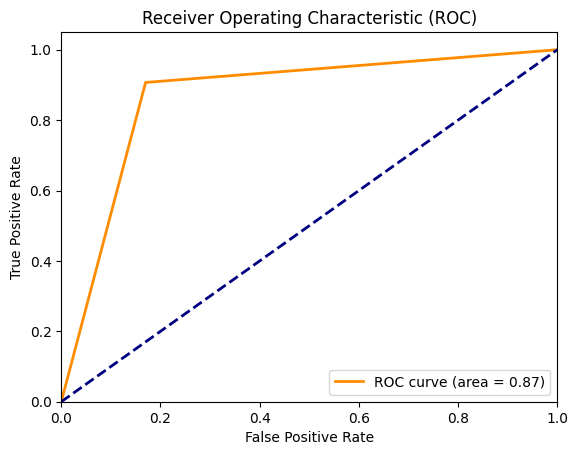

In [58]:
# ROC-AUC Score
roc_auc = roc_auc_score(all_labels, all_probs)
print(f"ROC-AUC: {roc_auc:.4f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc_value = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [44]:
model.eval()
sample_texts = ["I loved this movie!", "This was a terrible film.", "I hate you."]
inputs = tokenizer(sample_texts, padding=True, truncation=True, max_length=256, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)
    preds = torch.argmax(outputs.logits, dim=1)
    for text, pred in zip(sample_texts, preds):
        print(f"Text: {text} --> Sentiment: {'Positive' if pred==1 else 'Negative'}")

SequenceClassifierOutput(loss=None, logits=tensor([[-3.1254,  2.9388],
        [ 2.5213, -2.7813],
        [ 1.3939, -1.5337]], device='cuda:0'), hidden_states=None, attentions=None)
tensor([1, 0, 0], device='cuda:0')
Text: I loved this movie! --> Sentiment: Positive
Text: This was a terrible film. --> Sentiment: Negative
Text: I hate you. --> Sentiment: Negative


In [59]:
model.save_pretrained("my_model")
tokenizer.save_pretrained("my_model")

('my_model/tokenizer_config.json',
 'my_model/special_tokens_map.json',
 'my_model/vocab.txt',
 'my_model/added_tokens.json',
 'my_model/tokenizer.json')

In [60]:
!pip install huggingface_hub

In [61]:
from huggingface_hub import login
login()

In [64]:
# Example: changing labels
model.config.id2label = {0: "Negative", 1: "Positive"}
model.config.label2id = {"Negative": 0, "Positive": 1}

In [65]:
model.save_pretrained("my_model")
tokenizer.save_pretrained("my_model")

('my_model/tokenizer_config.json',
 'my_model/special_tokens_map.json',
 'my_model/vocab.txt',
 'my_model/added_tokens.json',
 'my_model/tokenizer.json')

In [66]:
from huggingface_hub import HfApi, HfFolder, Repository

model.push_to_hub("my-model-name")
tokenizer.push_to_hub("my-model-name")

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ..._yp591_/model.safetensors:   9%|9         | 25.2MB /  268MB            

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/omkarwazulkar/my-model-name/commit/44dbc8a4d475afb619311a84ad9470debf498adc', commit_message='Upload tokenizer', commit_description='', oid='44dbc8a4d475afb619311a84ad9470debf498adc', pr_url=None, repo_url=RepoUrl('https://huggingface.co/omkarwazulkar/my-model-name', endpoint='https://huggingface.co', repo_type='model', repo_id='omkarwazulkar/my-model-name'), pr_revision=None, pr_num=None)

In [67]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-classification", model="omkarwazulkar/my-model-name")

config.json:   0%|          | 0.00/634 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cuda:0


In [68]:
results = pipe(sample_texts)

for text, res in zip(sample_texts, results):
    print(f"Text: {text}")
    print(f"Prediction: {res}\n")

Text: I loved this movie!
Prediction: {'label': 'Positive', 'score': 0.9976807832717896}

Text: This was a terrible film.
Prediction: {'label': 'Negative', 'score': 0.9950457811355591}

Text: I hate you.
Prediction: {'label': 'Negative', 'score': 0.9491955637931824}



In [73]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("omkarwazulkar/my-model-name")
_model = AutoModelForSequenceClassification.from_pretrained("omkarwazulkar/my-model-name")

In [74]:
_model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [75]:
import torch

# Tokenize
inputs = tokenizer(sample_texts, padding=True, truncation=True, max_length=256, return_tensors="pt")

# Forward pass
with torch.no_grad():
    outputs = _model(**inputs)
    preds = torch.argmax(outputs.logits, dim=1)
    for text, pred in zip(sample_texts, preds):
      print(f"Text: {text} --> Sentiment: {'Positive' if pred==1 else 'Negative'}")

Text: I loved this movie! --> Sentiment: Positive
Text: This was a terrible film. --> Sentiment: Negative
Text: I hate you. --> Sentiment: Negative
